# **FC-DNN**

In [ ]:
!pip install mne
!pip install mne_bids
!pip install pydub
!pip install librosa==0.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.1/213.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.9 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.1
    Uninstalling librosa-0.10.1:
      Successfully uninstalled librosa-0.10.1


In [ ]:
import numpy as np
import mne
import pandas as pd
import mne_bids
import matplotlib.pyplot as plt
import soundfile as sf
import os
import pickle
from datetime import datetime, timedelta
from pydub import AudioSegment
import WaveGlow_functions
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import tensorflow as tf
import scipy.signal
import scipy.io as sio
import librosa

In [ ]:
# do not use all GPU memory
import tensorflow.compat.v1 as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### **Helper functions**

In [ ]:
#Small helper function to speed up the hilbert transform by extending the length of data to the next power of 2
hilbert3 = lambda x: scipy.signal.hilbert(
    x, scipy.fftpack.next_fast_len(len(x)), axis=0)[:len(x)]

In [ ]:
def extractHG(data,
              sr,
              windowLength=0.05,
              frameshift=0.01,
              bandpass_min=1,
              bandpass_max=70):
    """
    Window data and extract frequency-band envelope using the hilbert transform

    Parameters
    ----------
    data: array (samples, channels)
        EEG time series
    sr: int
        Sampling rate of the data
    windowLength: float
        Length of window (in seconds) in which spectrogram will be calculated
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    Returns
    ----------
    feat: array (windows, channels)
        Frequency-band feature matrix
    """
    #Linear detrend
    data = scipy.signal.detrend(data, axis=0)
    #Number of windows
    numWindows = int(
        np.floor((data.shape[0] - windowLength * sr) / (frameshift * sr)))
    #Filter High-Gamma Band
    # sos = scipy.signal.iirfilter(4, [70/(sr/2),170/(sr/2)],btype='bandpass',output='sos')
    sos = scipy.signal.iirfilter(
        4, [bandpass_min / (sr / 2), bandpass_max / (sr / 2)],
        btype='bandpass',
        output='sos')
    data = scipy.signal.sosfiltfilt(sos, data, axis=0)
    #Attenuate first harmonic of line noise
    # sos = scipy.signal.iirfilter(4, [98/(sr/2),102/(sr/2)],btype='bandstop',output='sos')
    # data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate second harmonic of line noise
    # sos = scipy.signal.iirfilter(4, [148/(sr/2),152/(sr/2)],btype='bandstop',output='sos')
    # data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Create feature space
    data = np.abs(hilbert3(data))
    feat = np.zeros((numWindows, data.shape[1]))
    for win in range(numWindows):
        start = int(np.floor((win * frameshift) * sr))
        stop = int(np.floor(start + windowLength * sr))
        feat[win, :] = np.mean(data[start:stop, :], axis=0)
    return feat

In [ ]:
def stackFeatures(features, modelOrder=4, stepSize=5):
    """
    Add temporal context to each window by stacking neighboring feature vectors

    Parameters
    ----------
    features: array (windows, channels)
        Feature time series
    modelOrder: int
        Number of temporal context to include prior to and after current window
    stepSize: float
        Number of temporal context to skip for each next context (to compensate for frameshift)
    Returns
    ----------
    featStacked: array (windows, feat*(2*modelOrder+1))
        Stacked feature matrix
    """
    featStacked = np.zeros((features.shape[0] - (2 * modelOrder * stepSize),
                            (2 * modelOrder + 1) * features.shape[1]))
    for fNum, i in enumerate(
            range(modelOrder * stepSize,
                  features.shape[0] - modelOrder * stepSize)):
        ef = features[i - modelOrder * stepSize:i + modelOrder * stepSize +
                      1:stepSize, :]
        featStacked[
            fNum, :] = ef.flatten()  #Add 'F' if stacked the same as matlab
    return featStacked

In [ ]:
# WaveGlow / Tacotron2 / STFT parameters for audio data
samplingFrequency = 22050
#samplingFrequency_EEG = 512 #sub 07
winL_EEG = 0.05
# frameshift_EEG = 0.01 # 10 ms
frameshift_EEG = 0.01  # 10 ms
frameshift_speech = 220  # 10ms
# modelOrder_EEG = 1
# modelOrder_EEG = 2
modelOrder_EEG = 4
# modelOrder_EEG = 10
stepSize_EEG = 5

In [ ]:
stft = WaveGlow_functions.TacotronSTFT(filter_length=1024,
                                       hop_length=frameshift_speech,
                                       win_length=1024,
                                       n_mel_channels=80,
                                       sampling_rate=samplingFrequency,
                                       mel_fmin=0,
                                       mel_fmax=8000)

/content/WaveGlow_functions.py:136: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/content/WaveGlow_functions.py:222: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [ ]:
# # Load the original audio file
# y, sr = librosa.load('data/stimuli/6min.wav', sr=None)  # Load with original sampling rate

# print("Sampling rate before:", sr, "Hz")
# # Resample to 22050 Hz
# y_22050 = librosa.resample(y, orig_sr=sr, target_sr=22050)

# # Save the resampled audio to a new file
# sf.write('resampled_audio_22050Hz.wav', y_22050, 22050)

# # Use the resampled file in your processing pipeline
# wavfile = 'resampled_audio_22050Hz.wav'

In [ ]:
# # Load the resampled audio file
# y, sr = librosa.load('resampled_audio_22050Hz.wav', sr=22050)

# # Shift the audio by 150 ms
# shift_ms = 150  # milliseconds
# shift_samples = int(sr * (shift_ms / 1000.0))  # Convert milliseconds to samples
# shifted_audio = np.pad(y, (shift_samples, 0), mode='constant', constant_values=(0, 0))

# # Save the shifted audio to a new file
# sf.write('shifted_audio_22050Hz.wav', shifted_audio, sr)

In [ ]:
# Now you can compute the mel-spectrogram of the shifted audio
wavfile = 'shifted_audio_22050Hz.wav'
mel_data = WaveGlow_functions.get_mel(wavfile, stft)
mel_data_nonrot = mel_data
mel_data = np.fliplr(np.rot90(mel_data.data.numpy(), axes=(1, 0)))


# Print shapes and durations

# print("Original audio duration (seconds):", len(y) / sr)
# print("Shifted audio duration (seconds):", len(shifted_audio) / sr)

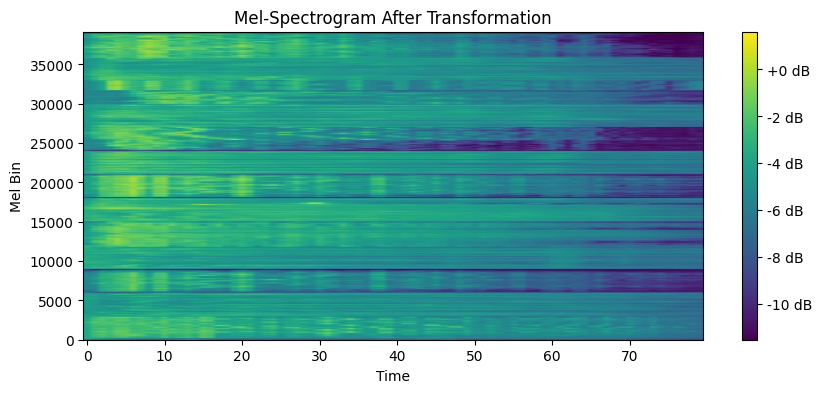

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Plot the waveform
# plt.figure(figsize=(10, 4))
# plt.plot(np.linspace(0, len(y) / sr, len(y)), y)
# plt.title('Waveform of Audio File')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.show()

# Plot the mel-spectrogram before rotation and flipping
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(librosa.power_to_db(mel_data_nonrot, ref=np.max), sr=sr, hop_length=512, y_axis='mel', x_axis='time')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-Spectrogram Before Transformation')
# plt.show()

# Plot the mel-spectrogram after rotation and flipping
plt.figure(figsize=(10, 4))
plt.imshow(mel_data, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram After Transformation')
plt.xlabel('Time')
plt.ylabel('Mel Bin')
plt.show()

### **Load Audio**

# Shift audio by 150 ms
shifted_audio = audio._spawn(audio.raw_data,
                             overrides={
                                 'frame_rate': audio.frame_rate,
                                 'frame_width': audio.sample_width
                             })
shifted_audio = shifted_audio._spawn(
    shifted_audio.raw_data,
    overrides={'frame_rate': shifted_audio.frame_rate + int(22050 * 0.15)})
shifted_audio = shifted_audio.set_frame_rate(audio.frame_rate)
shifted_audio = shifted_audio.set_channels(audio.channels)

# Export shifted audio as WAV file
shifted_audio.export('shifted_audio.wav', format='wav')

#Load Audio
wavfile = 'shifted_audio.wav'
mel_data = WaveGlow_functions.get_mel(wavfile, stft)
og_mel_data = mel_data
mel_data = np.fliplr(np.rot90(mel_data.data.numpy(), axes=(1, 0)))
og_mel_data_flipped= mel_data
#mel_data = mel_data.data.numpy()


print(mel_data.shape)
# Print out the duration of the original and shifted audio
print("Original audio duration:", audio.duration_seconds)
print("Shifted audio duration:", shifted_audio.duration_seconds)

In [ ]:
#Load Subjects
bids_dir = '/content/drive/MyDrive/btp'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')
#Choose subjects
# subject = '13'
subject = '38'
acquisition = 'clinical'
task = 'film'
datatype = 'ieeg'
session = 'iemu'

In [ ]:
#load subject's channels
channels_path = mne_bids.BIDSPath(subject=subject,
                                  session=session,
                                  suffix='channels',
                                  extension='tsv',
                                  datatype=datatype,
                                  task=task,
                                  acquisition=acquisition,
                                  root=bids_dir)

<ipython-input-54-5ce59b791b62>:2: FutureWarning: extension should start with a period ".", but got: "tsv". Prepending "." to form: ".tsv". This will raise an exception starting with MNE-BIDS 0.12.
  channels_path = mne_bids.BIDSPath(subject=subject,


In [ ]:
channels = pd.read_csv(str(channels_path.match()[0]),
                       sep='\t',
                       header=0,
                       index_col=None)
#print(channels)

In [ ]:
#set channel types
data_path = mne_bids.BIDSPath(subject=subject,
                              session=session,
                              suffix='ieeg',
                              extension='vhdr',
                              datatype=datatype,
                              task=task,
                              acquisition=acquisition,
                              root=bids_dir)
raw = mne.io.read_raw_brainvision(str(data_path.match()[0]),
                                  scale=1.0,
                                  preload=False,
                                  verbose=True)
raw.set_channel_types({
    ch_name:
    str(x).lower() if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
    for ch_name, x in zip(raw.ch_names, channels['type'].values)
})
raw.drop_channels([
    raw.ch_names[i] for i, j in enumerate(raw.get_channel_types())
    if j == 'misc'
])

<ipython-input-56-eb87faae4872>:2: FutureWarning: extension should start with a period ".", but got: "vhdr". Prepending "." to form: ".vhdr". This will raise an exception starting with MNE-BIDS 0.12.
  data_path = mne_bids.BIDSPath(subject=subject,


Extracting parameters from /content/drive/MyDrive/btp/sub-38/ses-iemu/ieeg/sub-38_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...


<ipython-input-56-eb87faae4872>:14: RuntimeWarning: The unit for channel(s) AH+, ECG+, EMG+, EMG2, Orb+ has changed from V to NA.
  raw.set_channel_types({


Measurement date,"January 01, 1900 00:00:00 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,104 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


print(raw)

### Discard Bad Channels

In [ ]:
#bad channels
bad_channels = channels['name'][(channels['type'].isin(['ECOG', 'SEEG']))
                                & (channels['status'] == 'bad')].tolist()
raw.info['bads'].extend([ch for ch in bad_channels])
raw.drop_channels(raw.info['bads'])

Measurement date,"January 01, 1900 00:00:00 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,101 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


### Load Raw Data

In [ ]:
raw.load_data()

Reading 0 ... 210205  =      0.000 ...   410.557 secs...


Measurement date,"January 01, 1900 00:00:00 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,101 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


In [ ]:
n_eeg_channels = int(raw.info['nchan'])  # for subject 01
print('n_eeg_channels', n_eeg_channels)
# raise

n_eeg_channels 101


### Apply notch filter to remove line noise

In [ ]:
raw.notch_filter(freqs=np.arange(50, 251, 50))

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s


Measurement date,"January 01, 1900 00:00:00 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,101 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


### Apply common average reference to remove common noise and trends

In [ ]:
#CAR
raw_car, _ = mne.set_eeg_reference(raw.copy(), 'average')

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.


### Read annotation with event markers

In [ ]:
custom_mapping = {
    'Stimulus/music': 2,
    'Stimulus/speech': 1,
    'Stimulus/end task': 5
}  # 'Stimulus/task end' in laan
events, event_id = mne.events_from_annotations(raw_car,
                                               event_id=custom_mapping,
                                               use_rounding=False)

Used Annotations descriptions: ['Stimulus/end task', 'Stimulus/music', 'Stimulus/speech']


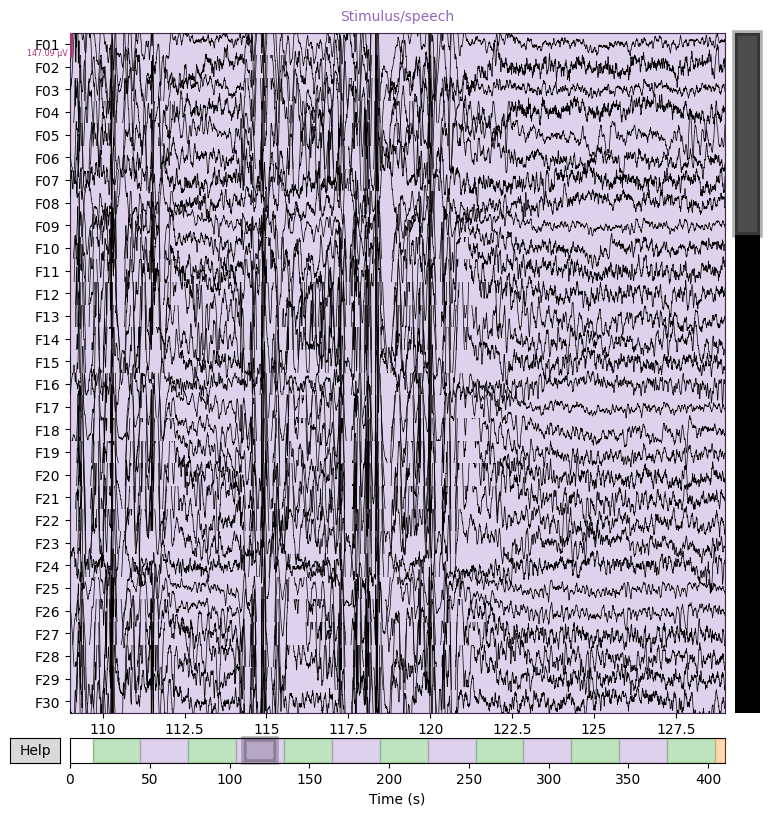

In [ ]:
#plotting
raw_car.plot(n_channels=30, scalings='auto', duration=20, start=109)
plt.show()

raise

In [ ]:
#get EEG SR
n_melspec = 80
samplingFrequency_EEG = raw_car.info['sfreq']

In [ ]:
eeg=raw_car.get_data()


#create a copy taht we crop
raw_car_cut = raw_car.get_data()
print(raw_car_cut.shape)
#(n_channels, n_times)

(101, 210206)


In [ ]:
print('before cut: ', raw_car._data.shape, mel_data.shape)

raw_car_cut = np.empty((n_eeg_channels, 0))
mel_data_cut = np.empty((0, n_melspec))

# for i in range(6):
for i in range(6):
    start_time = events[2 * i + 1, 0] / raw_car.info['sfreq']
    end_time = events[2 * i + 2, 0] / raw_car.info['sfreq']
    start_idx, end_idx = raw_car.time_as_index([start_time, end_time])
    print(i, 'iEEG index', start_idx, end_idx, end_idx - start_idx)
    n_frames_per_sec = int(1 / frameshift_EEG)
    print(i, 'melspec index', (2 * i + 1) * 30 * n_frames_per_sec,
          (2 * i + 2) * 30 * n_frames_per_sec,
          (2 * i + 2) * 30 * n_frames_per_sec -
          (2 * i + 1) * 30 * n_frames_per_sec)
    # raw_car_cut1 = raw_car._data[:, start_idx:end_idx]
    raw_car_cut1 = eeg[:, start_idx:end_idx]
    raw_car_cut = np.append(raw_car_cut, raw_car_cut1, axis=1)
    mel_data_cut1 = mel_data[(2 * i + 1) * 30 * n_frames_per_sec:(2 * i + 2) *
                             30 * n_frames_per_sec]
    mel_data_cut = np.append(mel_data_cut, mel_data_cut1, axis=0)
# raise
mel_data = mel_data_cut

print('after cut: ', raw_car_cut.shape, mel_data.shape)
# raise
#praat

before cut:  (101, 210206) (17956, 80)
0 iEEG index 22623 37983 15360
0 melspec index 3000 6000 3000
1 iEEG index 53375 68735 15360
1 melspec index 9000 12000 3000
2 iEEG index 84095 99455 15360
2 melspec index 15000 18000 3000
3 iEEG index 114815 130175 15360
3 melspec index 21000 24000 3000
4 iEEG index 145535 160895 15360
4 melspec index 27000 30000 3000
5 iEEG index 176255 191615 15360
5 melspec index 33000 36000 3000
after cut:  (101, 92160) (8956, 80)


In [ ]:
#get EEG SR
samplingFrequency_EEG = raw_car.info['sfreq']

# Calculate the length of the signal
length = raw_car_cut.shape[1] / samplingFrequency_EEG

print("The length of the EEG signal is", length, "s")
print(samplingFrequency_EEG)

The length of the EEG signal is 180.0 s
512.0


### Prepare Data for training

### Extract features

In [ ]:
#Extract HG features
print('calculating Hilbert...', raw_car_cut.shape)
# eeg_fft = np.empty((n_max_frames, n_freq_bands, n_eeg_channels * (2 * modelOrder_EEG + 1) ))
# feat_Hilbert_1 = extractHG(raw_car_cut,samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=1, bandpass_max=200)
feat_Hilbert_1 = extractHG(np.rot90(raw_car_cut),
                           samplingFrequency_EEG,
                           windowLength=winL_EEG,
                           frameshift=frameshift_EEG,
                           bandpass_min=1,
                           bandpass_max=70)
# feat_Hilbert_2 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=51, bandpass_max=100)
# feat_Hilbert_3 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=101, bandpass_max=150)
# feat_Hilbert_4 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=151, bandpass_max=200)

calculating Hilbert... (101, 92160)


In [ ]:
#Stack features
feat_Hilbert_1 = stackFeatures(feat_Hilbert_1,
                               modelOrder=modelOrder_EEG,
                               stepSize=stepSize_EEG)

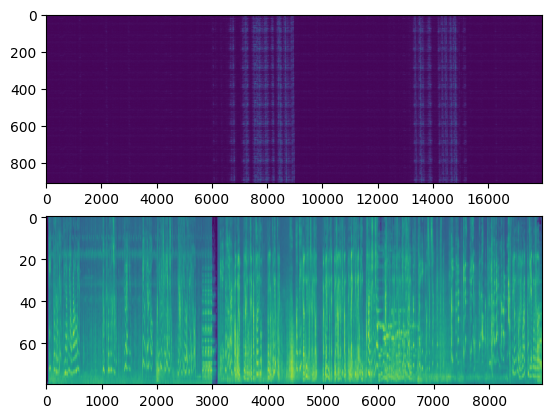

mel & iEEG:  (8956, 80) (17955, 909)


In [ ]:
plt.subplot(211)
plt.imshow(np.rot90(feat_Hilbert_1), aspect='auto')

plt.subplot(212)
plt.imshow(np.rot90(mel_data), aspect='auto')
plt.show()

eeg = feat_Hilbert_1
print('mel & iEEG: ', mel_data.shape, feat_Hilbert_1.shape)

In [ ]:
min_len = np.min((len(eeg), len(mel_data)))
eeg = eeg[0:min_len]
mel_data = mel_data[0:min_len]

In [ ]:
print('mel & iEEG: ', mel_data.shape, eeg.shape)

mel & iEEG:  (8956, 80) (8956, 909)


In [ ]:
train_index = np.arange(0, int(0.8 * eeg.shape[0]))
test_index = np.arange(int(0.8 * eeg.shape[0]), eeg.shape[0])

In [ ]:
# train-validation-test split
eeg_train = eeg[0:int(len(eeg) * 0.8)]
eeg_valid = eeg[int(len(eeg) * 0.8):int(len(eeg) * 0.9)]
eeg_test = eeg[int(len(eeg) * 0.9):]

In [ ]:
melspec_train = mel_data[0:int(len(mel_data) * 0.8)]
melspec_valid = mel_data[int(len(mel_data) * 0.8):int(len(mel_data) * 0.9)]
melspec_test = mel_data[int(len(mel_data) * 0.9):]

In [ ]:
# scale input to [0-1]
eeg_scaler = MinMaxScaler()
# eeg_scaler = StandardScaler(with_mean=True, with_std=True)
eeg_train_scaled = eeg_scaler.fit_transform(eeg_train)
eeg_valid_scaled = eeg_scaler.transform(eeg_valid)
eeg_test_scaled = eeg_scaler.transform(eeg_test)

In [ ]:
# scale outpit mel-spectrogram data to zero mean, unit variances
melspec_scaler = StandardScaler(with_mean=True, with_std=True)
melspec_train_scaled = melspec_scaler.fit_transform(melspec_train)
melspec_valid_scaled = melspec_scaler.transform(melspec_valid)
melspec_test_scaled = melspec_scaler.transform(melspec_test)

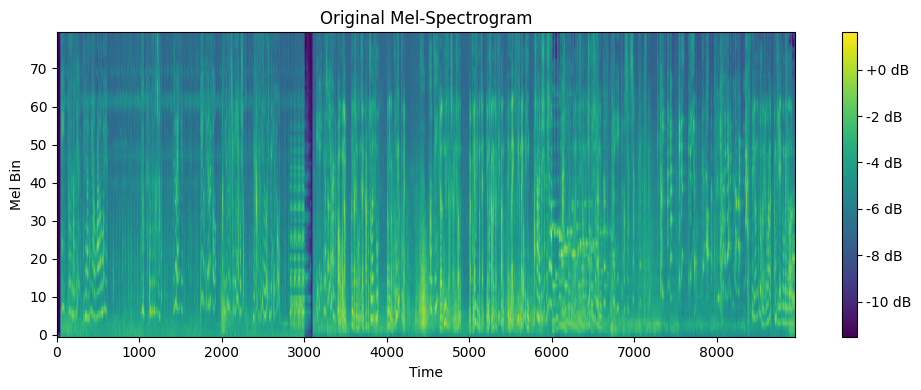

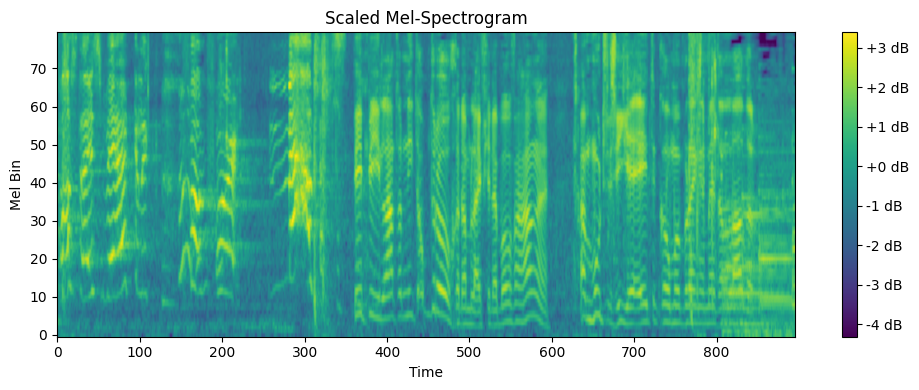

In [ ]:
import matplotlib.pyplot as plt

# Assuming mel_data is your original mel-spectrogram and melspec_test_scaled is the scaled version
# Also assuming both are NumPy arrays

# Plot original mel-spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_data.T, aspect='auto', origin='lower')
plt.title('Original Mel-Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Bin')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# Plot scaled mel-spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(melspec_test_scaled.T, aspect='auto', origin='lower')
plt.title('Scaled Mel-Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Bin')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


### FC-DNN

In [ ]:
# 5 hidden layers, with 1000 neuron on each layer
model = Sequential()
model.add(
    Dense(1000,
          input_dim=eeg_train_scaled.shape[1],
          kernel_initializer='normal',
          activation='relu'))
model.add(
    Dense(1000,
          input_dim=eeg_train_scaled.shape[1],
          kernel_initializer='normal',
          activation='relu'))
model.add(
    Dense(1000,
          input_dim=eeg_train_scaled.shape[1],
          kernel_initializer='normal',
          activation='relu'))
model.add(Dense(80, kernel_initializer='normal', activation='linear'))

In [ ]:
# compile model
model.compile(loss='mean_squared_error',
              metrics=['mean_squared_error'],
              optimizer='adam')
earlystopper = EarlyStopping(monitor='val_mean_squared_error',
                             min_delta=0.0001,
                             patience=5,
                             verbose=1,
                             mode='auto')

if not (os.path.isdir('models_iEEG_to_melspec/')):
    os.mkdir('models_iEEG_to_melspec/')

In [ ]:
# early stopping to avoid over-training
# csv logger
current_date = '{date:%Y-%m-%d_%H-%M-%S}'.format(date=datetime.now())
print(current_date)
# n_eeg_channels * (2 * modelOrder_EEG + 1)
model_name = 'models_iEEG_to_melspec/iEEG-Hilbert_to_melspec_DNN_modelOrder-' + str(
    modelOrder_EEG).zfill(
        2) + '_freqBands-1_' + '_sub' + subject + '_' + current_date
logger = CSVLogger(model_name + '.csv', append=True, separator=';')
checkp = ModelCheckpoint(model_name + '_weights_best.h5',
                         monitor='val_loss',
                         verbose=1,
                         save_best_only=True,
                         mode='min')

2024-02-04_12-21-54


serialize scalers to pickle
pickle.dump(eeg_scaler, open(model_name + '_eeg_scaler.sav', 'wb'))
pickle.dump(melspec_scaler, open(model_name + '_melspec_scaler.sav', 'wb'))

### Run training

In [ ]:
history = model.fit(
    eeg_train_scaled,
    melspec_train_scaled,
    epochs=100,
    batch_size=32,
    shuffle=True,
    verbose=1,
    callbacks=[logger, checkp],
    validation_split=0.9,
    validation_data=(eeg_valid_scaled, melspec_valid_scaled),
)

Epoch 1/100
216/224 [===========================>..] - ETA: 0s - loss: 0.9013 - mean_squared_error: 0.9013
Epoch 1: val_loss improved from inf to 1.18991, saving model to models_iEEG_to_melspec/iEEG-Hilbert_to_melspec_DNN_modelOrder-04_freqBands-1__sub38_2024-02-04_12-21-54_weights_best.h5
224/224 [==============================] - 2s 5ms/step - loss: 0.9006 - mean_squared_error: 0.9006 - val_loss: 1.1899 - val_mean_squared_error: 1.1899
Epoch 2/100
 13/224 [>.............................] - ETA: 0s - loss: 0.7499 - mean_squared_error: 0.7499

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


218/224 [============================>.] - ETA: 0s - loss: 0.6687 - mean_squared_error: 0.6687
Epoch 2: val_loss did not improve from 1.18991
224/224 [==============================] - 1s 5ms/step - loss: 0.6664 - mean_squared_error: 0.6664 - val_loss: 1.9159 - val_mean_squared_error: 1.9159
Epoch 3/100
222/224 [============================>.] - ETA: 0s - loss: 0.5158 - mean_squared_error: 0.5158
Epoch 3: val_loss did not improve from 1.18991
224/224 [==============================] - 1s 6ms/step - loss: 0.5167 - mean_squared_error: 0.5167 - val_loss: 1.8754 - val_mean_squared_error: 1.8754
Epoch 4/100
223/224 [============================>.] - ETA: 0s - loss: 0.4169 - mean_squared_error: 0.4169
Epoch 4: val_loss did not improve from 1.18991
224/224 [==============================] - 1s 4ms/step - loss: 0.4167 - mean_squared_error: 0.4167 - val_loss: 1.4319 - val_mean_squared_error: 1.4319
Epoch 5/100
216/224 [===========================>..] - ETA: 0s - loss: 0.3304 - mean_squared_erro

In [ ]:
# save model
model_json = model.to_json()
with open(model_name + '_model.json', "w") as json_file:
    json_file.write(model_json)

# here the training of the DNN is finished
# load back best weights
model.load_weights(model_name + '_weights_best.h5')
# remove model file
# os.remove(model_name + '_weights_best.h5')

### Visualize predicted melspectogram

28/28 [==============================] - 0s 3ms/step
Best validation MSE: 1.1899
Minimum training loss: 0.0226


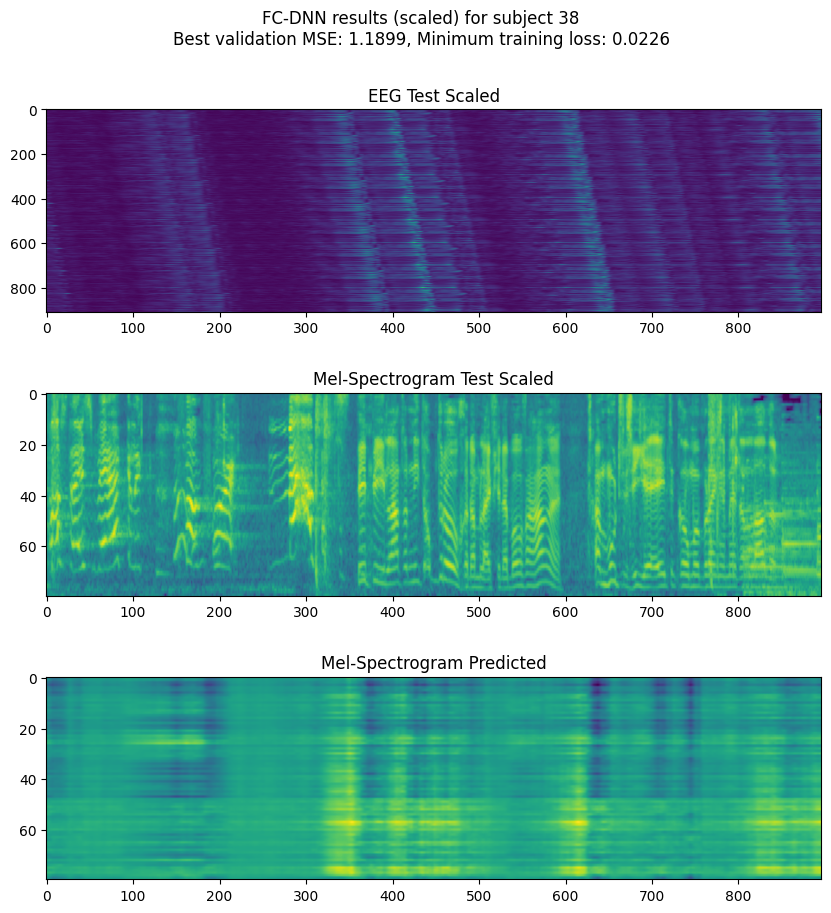

In [ ]:
# melspec_predicted = model.predict(eeg_test_scaled[0:500])
melspec_predicted = model.predict(eeg_test_scaled[0:1000])
# melspec_predicted = melspec_predicted[0:500]
# test_melspec = test_melspec[]

#best stuff

best_val_mse = min(history.history['val_mean_squared_error'])
print(f'Best validation MSE: {best_val_mse:.4f}')

min_train_loss = min(history.history['loss'])
print(f'Minimum training loss: {min_train_loss:.4f}')

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].imshow(np.rot90(eeg_test_scaled[0:1000]), aspect='auto')
axs[0].set_title('EEG Test Scaled')
axs[1].imshow(np.rot90(melspec_test_scaled[0:1000]), aspect='auto')
axs[1].set_title('Mel-Spectrogram Test Scaled')
axs[2].imshow(np.rot90(melspec_predicted[0:1000]), aspect='auto')
axs[2].set_title('Mel-Spectrogram Predicted')
plt.suptitle(
    f'FC-DNN results (scaled) for subject {subject}\nBest validation MSE: {best_val_mse:.4f}, Minimum training loss: {min_train_loss:.4f}'
)
plt.subplots_adjust(hspace=0.4)

plt.savefig(model_name + '_EEG_scaled_plots.png')
plt.show()

### Audio synth

In [ ]:
# Provide the actual mel spectrogram (melspec_predicted) and sampling frequency (samplingFrequency) from your FC-DNN output
samplingFrequency = 16000

# Convert mel spectrogram to audio using Griffin-Lim algorithm
audio = librosa.feature.inverse.mel_to_audio(melspec_predicted,
                                             sr=samplingFrequency)

# Save the audio to a WAV file
output_file = subject + ' predicted_audio_fc-DNN.wav'
sf.write(output_file, audio, samplingFrequency)

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


# **Metrics and Scores**

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from scipy.special import kl_div
from scipy.stats import pearsonr

ground_truth_mel_spectrogram = melspec_test_scaled[0:1000]
predicted_mel_spectrogram = melspec_predicted[0:1000]

ssim_score = ssim(ground_truth_mel_spectrogram, predicted_mel_spectrogram)
mse = mean_squared_error(ground_truth_mel_spectrogram, predicted_mel_spectrogram)
psnr = 10 * np.log10(1.0 / mse)
cosine_similarity = 1 - cosine(ground_truth_mel_spectrogram.flatten(), predicted_mel_spectrogram.flatten())
kl_divergence = kl_div(ground_truth_mel_spectrogram.flatten(), predicted_mel_spectrogram.flatten())

pearson_corr, _ = pearsonr(ground_truth_mel_spectrogram.flatten(), predicted_mel_spectrogram.flatten())

print(f"SSIM: {ssim_score}\nMSE: {mse}\nPSNR: {psnr}\nCosine Similarity: {cosine_similarity}\nKL Divergence: {kl_divergence}\nPearson Correlation: {pearson_corr}")

SSIM: 0.0041237471028173385
MSE: 1.1990440242827356
PSNR: -0.7883512901382804
Cosine Similarity: -0.03990827065003444
KL Divergence: [       inf        inf 0.25197178 ...        inf        inf        inf]
Pearson Correlation: -0.03349594570816805


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


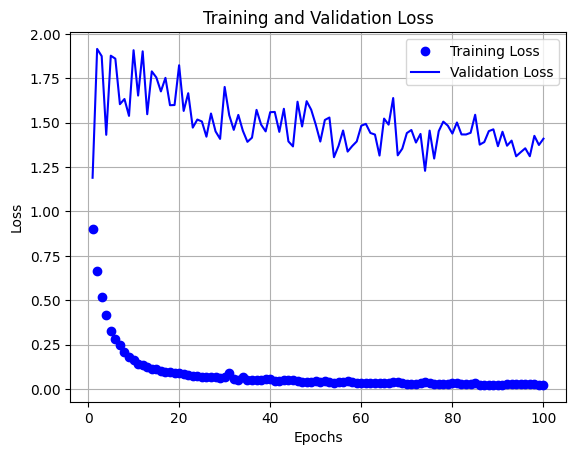

In [ ]:
import matplotlib.pyplot as plt

training_loss = history.history['mean_squared_error']
validation_loss = history.history['val_mean_squared_error']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()